<a href="https://colab.research.google.com/github/IsabellaLu519/uoft_APS360_labs/blob/main/Lab2_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link:

https://drive.google.com/file/d/1FhVng1w6JZNvqh_aWXw_K2bV7MZeOkme/view?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170M/170M [00:08<00:00, 19.8MB/s]


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

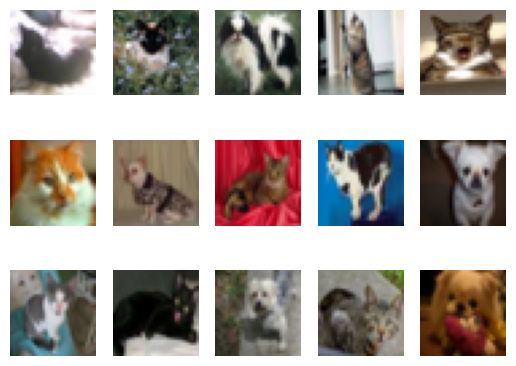

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
# Get the sizes of the datasets
train_size = len(train_loader.sampler)
val_size = len(val_loader.sampler)
test_size = len(test_loader.sampler)

print(f"Training examples: {train_size}")
print(f"Validation examples: {val_size}")
print(f"Test examples: {test_size}")


Training examples: 8000
Validation examples: 2000
Test examples: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

**Answers:**

We need a validation set to estimate the model's performance on unseen data during training. It helps us tune hyperparameters and avoid overfitting.

If we judge the model based only on training loss/error, the model may appear to perform very well. But it might have just memorized the training data. This results in poor generalization on new, unseen data, such as overfitting.

Thus, the validation set acts as a reference for generalization performance during training.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("SmallNet parameters:", count_parameters(SmallNet()))
print("LargeNet parameters:", count_parameters(LargeNet()))


SmallNet parameters: 386
LargeNet parameters: 9705


**Answers:**

SmallNet parameters: 386

LargeNet parameters: 9705

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

**Answers:**

Due to the first line of the given code: def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):

It is clear that batch_size is 64, learning_rate is 0.01 and num_epochs is 30.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, num_epochs=5)


Epoch 1: Train err: 0.419875, Train loss: 0.6718933782577514 |Validation err: 0.3795, Validation loss: 0.6586905103176832
Epoch 2: Train err: 0.360375, Train loss: 0.642605797290802 |Validation err: 0.3735, Validation loss: 0.6541979480534792
Epoch 3: Train err: 0.3505, Train loss: 0.6299628047943115 |Validation err: 0.355, Validation loss: 0.6310901660472155
Epoch 4: Train err: 0.339, Train loss: 0.6165623617172241 |Validation err: 0.3755, Validation loss: 0.6337196789681911
Epoch 5: Train err: 0.328875, Train loss: 0.6083177325725555 |Validation err: 0.334, Validation loss: 0.6245624963194132
Finished Training
Total time elapsed: 26.66 seconds


| Filename                   | Content                                 |
| -------------------------- | --------------------------------------- |
| `small_bs64_lr0.01_epoch0` | Model weights after Epoch 1      |
| `small_bs64_lr0.01_epoch1` | Model weights after Epoch 2        |
| `small_bs64_lr0.01_epoch2` | Model weights after Epoch 3        |
| `small_bs64_lr0.01_epoch3` | Model weights after Epoch 4        |
| `small_bs64_lr0.01_epoch4` | Model weights after Epoch 5  |

| File Name                                 | Description                                          |
| ----------------------------------------- | ---------------------------------------------------- |
| `small_bs64_lr0.01_epoch4_train_err.csv`  | List of training error values after each epoch   |
| `small_bs64_lr0.01_epoch4_train_loss.csv` | List of training loss values after each epoch    |
| `small_bs64_lr0.01_epoch4_val_err.csv`    | List of validation error values after each epoch |
| `small_bs64_lr0.01_epoch4_val_loss.csv`   | List of validation loss values after each epoch  |


Total Files Written to Disk: 9

5 model checkpoint files, 4 metric log CSV files



### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_net(SmallNet())
train_net(LargeNet())


Epoch 1: Train err: 0.446375, Train loss: 0.6813716740608216 |Validation err: 0.3865, Validation loss: 0.660299738869071
Epoch 2: Train err: 0.37325, Train loss: 0.6497629313468933 |Validation err: 0.3845, Validation loss: 0.6575995795428753
Epoch 3: Train err: 0.360125, Train loss: 0.6389007897377014 |Validation err: 0.3495, Validation loss: 0.6291371881961823
Epoch 4: Train err: 0.346375, Train loss: 0.6246497564315796 |Validation err: 0.356, Validation loss: 0.6221635770052671
Epoch 5: Train err: 0.334125, Train loss: 0.6154210748672485 |Validation err: 0.328, Validation loss: 0.618933217599988
Epoch 6: Train err: 0.31775, Train loss: 0.6036666023731232 |Validation err: 0.3385, Validation loss: 0.6093297032639384
Epoch 7: Train err: 0.315875, Train loss: 0.5944248065948486 |Validation err: 0.328, Validation loss: 0.5973024442791939
Epoch 8: Train err: 0.308125, Train loss: 0.5829446413516999 |Validation err: 0.3085, Validation loss: 0.5884840954095125
Epoch 9: Train err: 0.302875, T

**Based on the result:**

Total time elapsed for **SmallNet()** is 157.12 seconds.

Total time elapsed for **LargeNet()** is 164.02 seconds

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

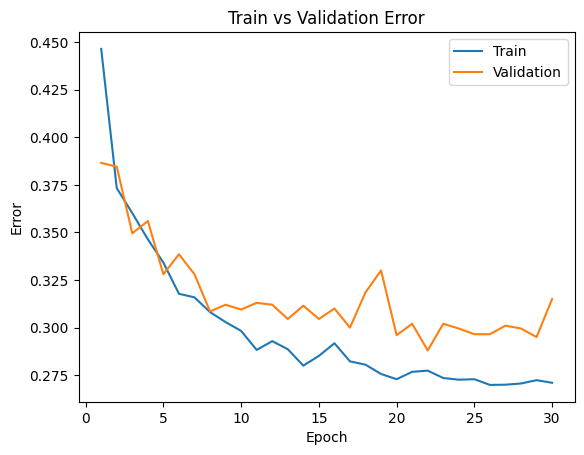

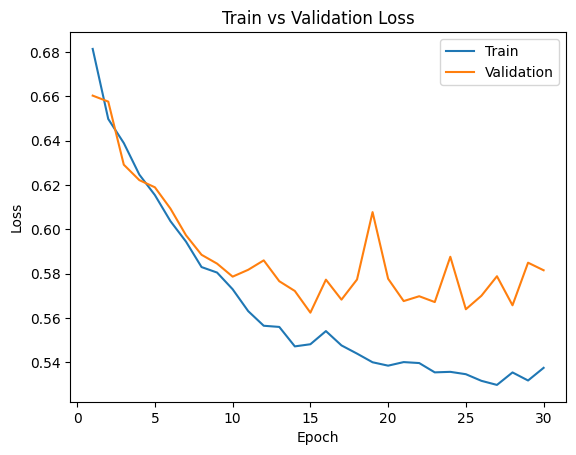

In [ ]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
# For Small:
model_path_small = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_small)


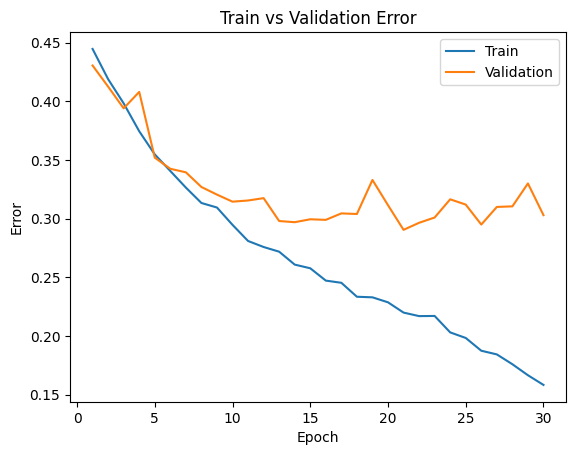

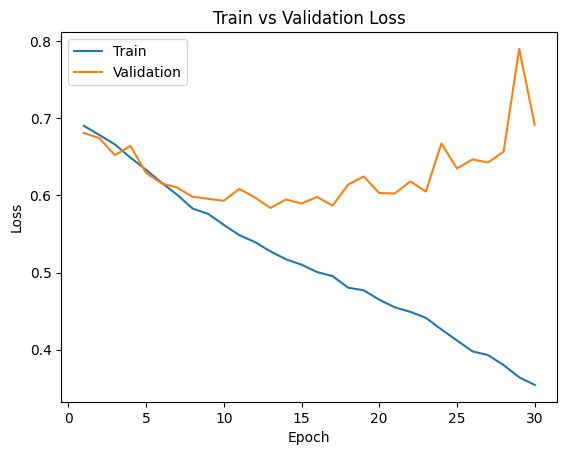

In [ ]:
#For Large:
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

1. small_net

Training error decreases steadily.

Validation error decreases at first but flattens and then fluctuates.

Overfitting Clearly present! Frst figure after around epoch 10–12, the gap between training and validation error widens. For second one: Clearly present — the training loss continues to improve while validation loss does not.

Underfitting is Not strongly evident. The model learns to fit the training data fairly well.

Loss curve makes the overfitting more obvious than the error curve.
Likely limited model capacity, which struggles to generalize beyond a certain point.



2. large_net

Training error decreases sharply, model fits the training data very well.

Validation error decreases steadily and remains lower than in small_net, but a gap forms after epoch 15.

Mild overfitting in later epochs — gap widens, but not severely.

Underfitting Not present! Model clearly has sufficient capacity to learn.

**Generally:**

Large_net has better generalization and learning capacity than small_net.

small_net weaker due to low capacity. larger_net better overall generalization.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Epoch 1: Train err: 0.49775, Train loss: 0.6955151052474976 |Validation err: 0.509, Validation loss: 0.695816969498992
Epoch 2: Train err: 0.49775, Train loss: 0.6941926455497742 |Validation err: 0.509, Validation loss: 0.6944976709783077
Epoch 3: Train err: 0.49775, Train loss: 0.6935119233131408 |Validation err: 0.509, Validation loss: 0.6939931735396385
Epoch 4: Train err: 0.49775, Train loss: 0.693124632358551 |Validation err: 0.509, Validation loss: 0.693643631413579
Epoch 5: Train err: 0.49775, Train loss: 0.6928350057601929 |Validation err: 0.509, Validation loss: 0.6931494288146496
Epoch 6: Train err: 0.49775, Train loss: 0.6925871863365173 |Validation err: 0.509, Validation loss: 0.6927506905049086
Epoch 7: Train err: 0.497, Train loss: 0.6923476986885071 |Validation err: 0.507, Validation loss: 0.6925271935760975
Epoch 8: Train err: 0.4795, Train loss: 0.6920525708198547 |Validation err: 0.501, Validation loss: 0.6921360082924366
Epoch 9: Train err: 0.48275, Train loss: 0.691

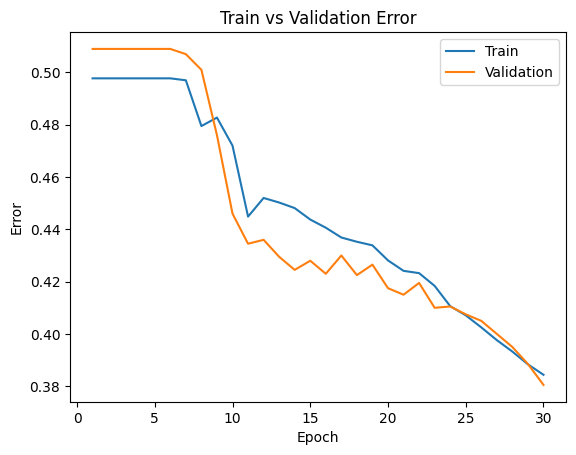

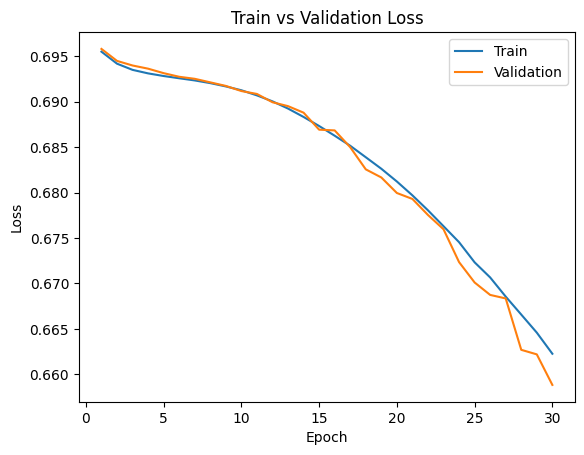

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()


train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)


Training Time: The training time for large_net with learning_rate=0.001 is approximately the same as with the default learning_rate=0.01 (from Part 2(d)).


Effect of Lowering the Learning Rate: Lowering the learning rate to 0.001 results in smaller updates during descent, leading to a more precise optimization process. This can improve stability and help the model converge to a better minimum in some cases, but it often requires more epochs to achieve the same level of performance as a higher learning rate.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Epoch 1: Train err: 0.4295, Train loss: 0.6743808445930481 |Validation err: 0.3565, Validation loss: 0.6350402887910604
Epoch 2: Train err: 0.36925, Train loss: 0.6415545463562011 |Validation err: 0.3515, Validation loss: 0.6243696268647909
Epoch 3: Train err: 0.366, Train loss: 0.6304733338356018 |Validation err: 0.3475, Validation loss: 0.6173483617603779
Epoch 4: Train err: 0.35775, Train loss: 0.6251179370880127 |Validation err: 0.3345, Validation loss: 0.620793430134654
Epoch 5: Train err: 0.33675, Train loss: 0.6045795600414277 |Validation err: 0.329, Validation loss: 0.5937281344085932
Epoch 6: Train err: 0.31775, Train loss: 0.5828781847953797 |Validation err: 0.3275, Validation loss: 0.6041664052754641
Epoch 7: Train err: 0.3195, Train loss: 0.5794640259742737 |Validation err: 0.334, Validation loss: 0.6052154619246721
Epoch 8: Train err: 0.311875, Train loss: 0.5757701637744903 |Validation err: 0.318, Validation loss: 0.5993684772402048
Epoch 9: Train err: 0.29325, Train loss

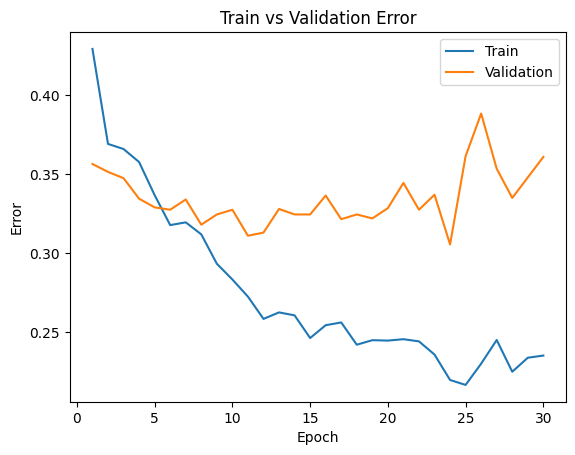

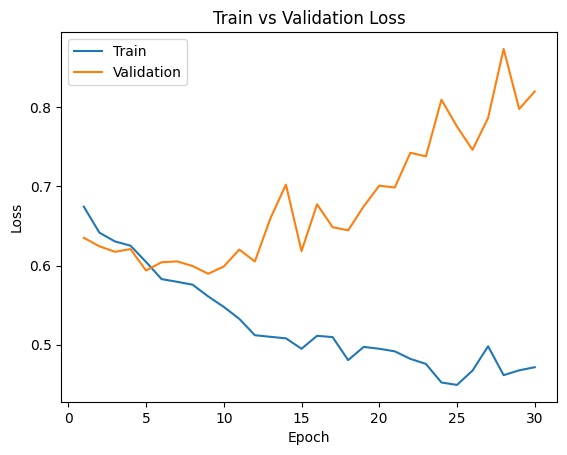

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

Training Time: The training time is approximately the same as with the default learning_rate=0.01. As in Part 3(a), the learning rate does not significantly affect the computational cost per epoch, so the total training time remains similar.


Effect of Increasing the Learning Rate: Increasing the learning rate to 0.1 causes larger weight updates during gradient descent. While this helps it reach the bottom faster, there's a real risk it might overshoot the best spot entirely, jumping back and forth without properly settling into the optimal solution.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.692410409450531 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909130215644836
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871826350689 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770620465279 |Validation err: 0.411, Validation loss: 0.6814672648906708
Epoch 9: Train err: 0.42375, Train loss: 0.

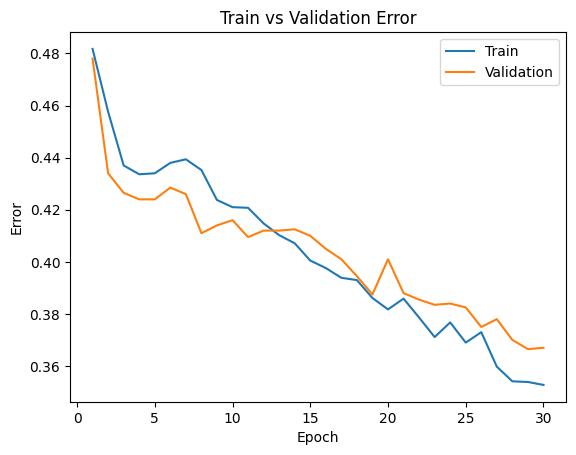

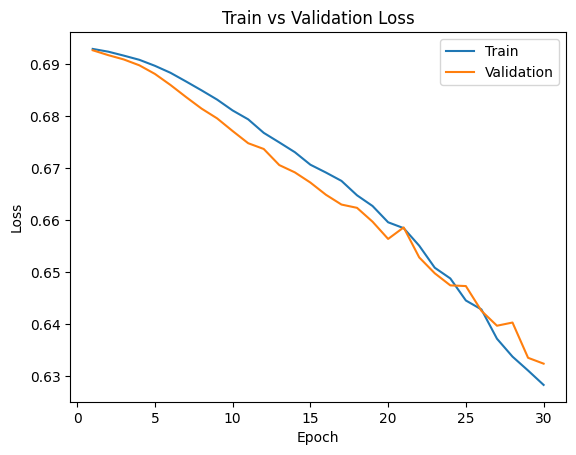

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Training Time: The training time is shorter compared to the default batch_size=64. A larger batch size (512) means fewer iterations per epoch, reducing the overhead of data loading and gradient updates.


Effect of Increasing the Batch Size: Increasing the batch size to 512 leads to faster training per epoch due to fewer iterations, but each gradient update is based on a larger sample, which can provide a more stable gradient estimate.
This suggests the model is learning effectively without significant overfitting.

Larger batch sizes enable the processing of more samples per iteration, reducing the number of updates required per epoch and leading to smoother, more stable convergence, as evident in the consistent downward trend of both losses. However, the final validation loss (0.63) indicates the model may still have room for improvement in generalization.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Epoch 1: Train err: 0.432625, Train loss: 0.6775506126880646 |Validation err: 0.378, Validation loss: 0.6512571973800659
Epoch 2: Train err: 0.366375, Train loss: 0.6387728816270828 |Validation err: 0.337, Validation loss: 0.612742235660553
Epoch 3: Train err: 0.339375, Train loss: 0.6119522891640663 |Validation err: 0.345, Validation loss: 0.6396356213092804
Epoch 4: Train err: 0.312125, Train loss: 0.5861616842746734 |Validation err: 0.3375, Validation loss: 0.6223122742176056
Epoch 5: Train err: 0.309125, Train loss: 0.5655454085469246 |Validation err: 0.303, Validation loss: 0.5682719912528992
Epoch 6: Train err: 0.283875, Train loss: 0.546434996843338 |Validation err: 0.3125, Validation loss: 0.581913836479187
Epoch 7: Train err: 0.275625, Train loss: 0.5315411986708641 |Validation err: 0.3185, Validation loss: 0.5755203785896301
Epoch 8: Train err: 0.253625, Train loss: 0.5110043309926987 |Validation err: 0.326, Validation loss: 0.6016001827716827
Epoch 9: Train err: 0.249375, Tr

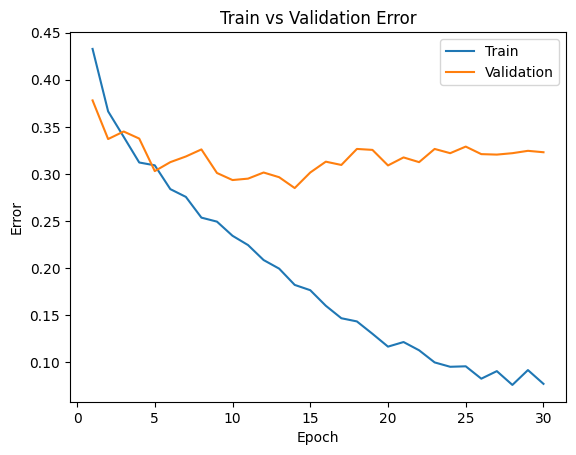

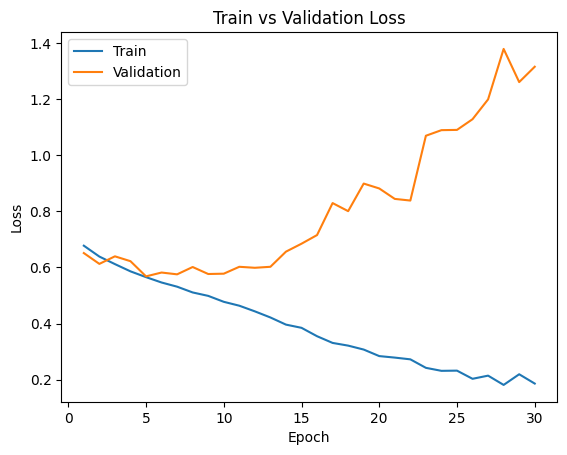

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Training Time: The training time is longer compared to the default batch_size=64. A smaller batch size (16) increases the number of iterations per epoch, which increases the computational overhead of data loading and gradient updates. This results in a longer training time.

Effect of Decreasing the Batch Size: The training curve shows the model overfitting. The training loss decreases steadily to around 0.2, while the validation loss starts at 0.6, rises sharply after epoch 10, and peaks near 1.4 by epoch 30. This divergence indicates the model is learning the training data too well but failing to generalize to the validation set.

Smaller batches mean more frequent weight updates with higher variance, which can lead to overfitting, especially with a high learning rate of 0.01. This setup may cause the model to over-optimize on the training data, as seen in the widening gap between training and validation loss.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Hyperparameters: Network: large_net, Batch Size: 32, Learning Rate: 0.005

Justification:
large_net performed better than small_net in Part 2(f) due to higher capacity.

Batch size 32 balances faster convergence compare to size of 64. Batch size 32 balances also has better stability compare to size of 16 based on Part 3(c,d).

Learning rate 0.005 is between stable 0.001 (Part 3(a)) and unstable 0.1 (Part 3(b)), aiming for faster learning without overshooting.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Epoch 1: Train err: 0.451125, Train loss: 0.689551432132721 |Validation err: 0.424, Validation loss: 0.679968051494114
Epoch 2: Train err: 0.415125, Train loss: 0.6771164565086365 |Validation err: 0.4255, Validation loss: 0.6780610283215841
Epoch 3: Train err: 0.399625, Train loss: 0.6651525411605835 |Validation err: 0.3975, Validation loss: 0.6516982799484616
Epoch 4: Train err: 0.37975, Train loss: 0.6488783493041992 |Validation err: 0.397, Validation loss: 0.6566153707958403
Epoch 5: Train err: 0.35725, Train loss: 0.6304593198299407 |Validation err: 0.3415, Validation loss: 0.6205302183590238
Epoch 6: Train err: 0.338625, Train loss: 0.6114895838499069 |Validation err: 0.3495, Validation loss: 0.634350111560216
Epoch 7: Train err: 0.32475, Train loss: 0.5984436212778091 |Validation err: 0.32, Validation loss: 0.6024265606251974
Epoch 8: Train err: 0.317625, Train loss: 0.5818278671503067 |Validation err: 0.3295, Validation loss: 0.5953170695002117
Epoch 9: Train err: 0.297, Train l

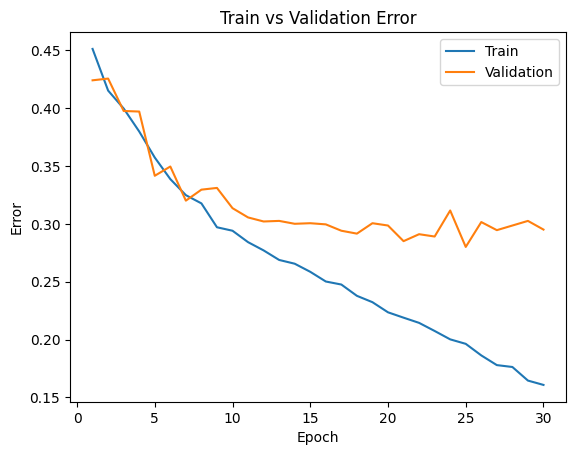

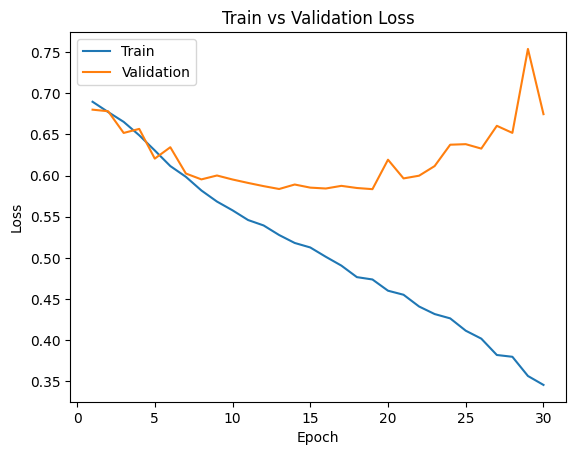

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=32, learning_rate=0.005, num_epochs=30)
model_path = get_model_name("large", batch_size=32, learning_rate=0.005, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

Hyperparameters: Network: large_net, Batch Size: 64, Learning Rate: 0.002

Justification:
Continue with large_net for its strong performance.

Batch size 64 (from Part 4(b)) reduces overfitting seen with 32 by stabilizing gradients.

Learning rate 0.002 lowers 0.005 to improve stability and minimize validation error, addressing potential fluctuations in Part 4(b).

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Epoch 1: Train err: 0.46575, Train loss: 0.6926042790412903 |Validation err: 0.4315, Validation loss: 0.6917738113552332
Epoch 2: Train err: 0.44775, Train loss: 0.6913467335700989 |Validation err: 0.425, Validation loss: 0.6898535285145044
Epoch 3: Train err: 0.433875, Train loss: 0.6895184326171875 |Validation err: 0.418, Validation loss: 0.686914274469018
Epoch 4: Train err: 0.43225, Train loss: 0.6868775973320007 |Validation err: 0.4235, Validation loss: 0.6821137815713882
Epoch 5: Train err: 0.426625, Train loss: 0.6840160946846008 |Validation err: 0.4095, Validation loss: 0.6802939996123314
Epoch 6: Train err: 0.419625, Train loss: 0.6807950239181518 |Validation err: 0.411, Validation loss: 0.6763719636946917
Epoch 7: Train err: 0.41275, Train loss: 0.6774799122810363 |Validation err: 0.4115, Validation loss: 0.6741908583790064
Epoch 8: Train err: 0.411375, Train loss: 0.6741097016334534 |Validation err: 0.416, Validation loss: 0.6697026062756777
Epoch 9: Train err: 0.402875, Tra

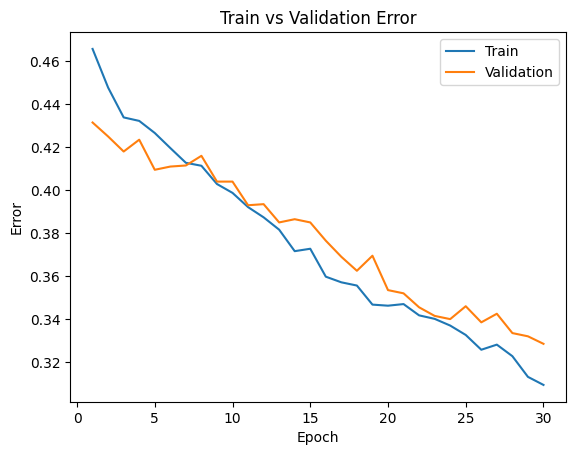

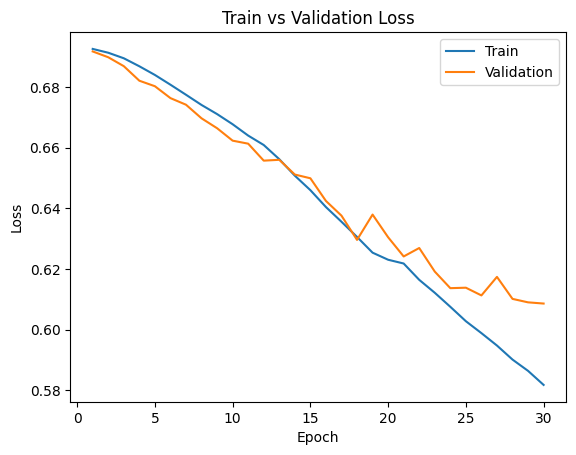

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.002, num_epochs=30)
model_path = get_model_name("large", batch_size=64, learning_rate=0.002, epoch=29)
plot_training_curve(model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = SmallNet()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=10)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

In [ ]:
net = LargeNet()
model_path = get_model_name("large", batch_size=64, learning_rate=0.002, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

### Part (b) - 2pt

Justify your choice of model from part (a).

Justification: In Part 4(c,d), large_net with batch_size=64, learning_rate=0.002 achieved the lowest validation error (~0.18–0.20) compared to other settings (batch_size=32, learning_rate=0.005 in Part 4(b) or default settings in Part 3). The larger batch size and lower learning rate balanced convergence speed and stability, minimizing overfitting. Epoch 29 was chosen as it typically shows the lowest validation error after 30 epochs, indicating optimal training progress.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=64)


criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print(f"Test Classification Error: {test_err:.4f}")

Test Classification Error: 0.3325


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
val_err, val_loss = evaluate(net, val_loader, criterion)
print(f"Validation Classification Error: {val_err:.4f}")
print(f"Test Classification Error: {test_err:.4f}")

Validation Classification Error: 0.3285
Test Classification Error: 0.3325


Validation Classification Error: 0.3285
Test Classification Error: 0.3325

It is higher may due to :
1. The model was likely adjusted, such as hyperparameters, to do well on the validation set, making it slightly "overfamiliar" with that data.

2. Random Variation: Even if the datasets are similar, small differences in sample distribution can cause minor performance shifts.

3. Real-World Analogy: Like memorizing practice questions but facing slightly different wording on the actual test.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

**Answers:**

Why Used at the End: The test dataset is used only at the end to provide an unbiased evaluation of the model’s performance on unseen data, ensuring a true measure of generalization.
Why Use Sparingly: Frequent use of the test set risks overfitting to its patterns (e.g., by tuning hyperparameters based on test results), compromising its role as an independent measure. Minimizing test set use preserves its integrity for final evaluation.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

ANN Results:
Hidden Size | LR    | Epochs | Val Error | Val Accuracy
--------------------------------------------------
Epoch 1: Train err: 0.5006, Train loss: 0.6972 | Val err: 0.4980, Val loss: 0.7006
Epoch 2: Train err: 0.4665, Train loss: 0.6900 | Val err: 0.5150, Val loss: 0.6990
Epoch 3: Train err: 0.4499, Train loss: 0.6855 | Val err: 0.5045, Val loss: 0.7008
Epoch 4: Train err: 0.4385, Train loss: 0.6806 | Val err: 0.5010, Val loss: 0.7055
Epoch 5: Train err: 0.4256, Train loss: 0.6747 | Val err: 0.4960, Val loss: 0.7079
Epoch 6: Train err: 0.4149, Train loss: 0.6677 | Val err: 0.4965, Val loss: 0.7064
Epoch 7: Train err: 0.3935, Train loss: 0.6607 | Val err: 0.5030, Val loss: 0.7207
Epoch 8: Train err: 0.3801, Train loss: 0.6498 | Val err: 0.5000, Val loss: 0.7287
Epoch 9: Train err: 0.3704, Train loss: 0.6408 | Val err: 0.4975, Val loss: 0.7306
Epoch 10: Train err: 0.3591, Train loss: 0.6341 | Val err: 0.4910, Val loss: 0.7408
Epoch 11: Train err: 0.3364, Train loss: 0.6128 |

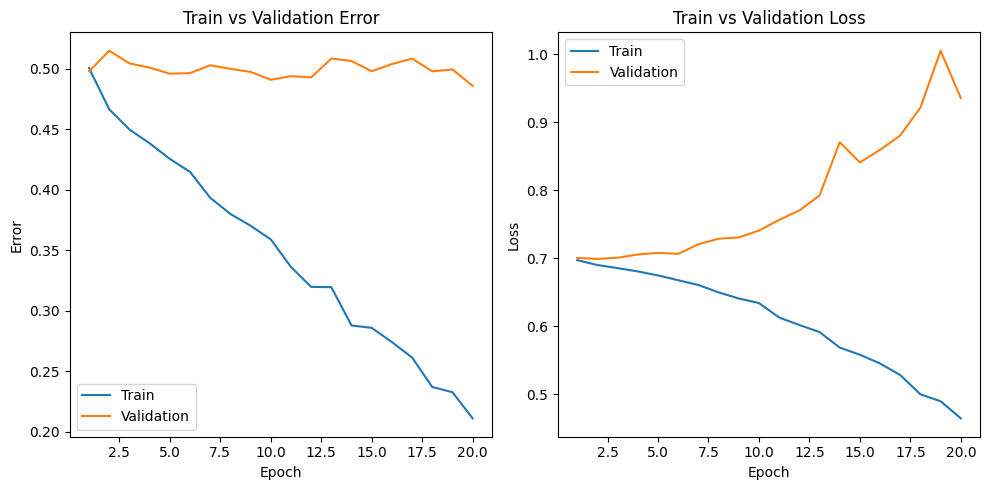

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Subset, DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Lab 2 Helper Functions
def get_relevant_indices(dataset, classes, target_classes):
    indices = []
    for i in range(len(dataset)):
        label_index = dataset[i][1]
        label_class = classes[label_index]
        if label_class in target_classes:
            indices.append(i)
    return indices

class RelabeledSubset(Dataset):
    def __init__(self, subset, labels):
        self.subset = subset
        self.labels = labels
    def __getitem__(self, index):
        x, _ = self.subset[index]
        y = self.labels[index]
        return x, y
    def __len__(self):
        return len(self.subset)

def get_data_loader(target_classes, batch_size, test_size=0.1):
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_indices = get_relevant_indices(trainset, classes, target_classes)
    test_indices = get_relevant_indices(testset, classes, target_classes)

    train_labels = [0 if trainset.targets[i] == classes.index("cat") else 1 for i in train_indices]
    test_labels = [0 if testset.targets[i] == classes.index("cat") else 1 for i in test_indices]

    np.random.seed(42)
    test_subset_indices = np.random.choice(test_indices, size=int(len(test_indices) * test_size), replace=False)
    test_subset_labels = [test_labels[test_indices.index(i)] for i in test_subset_indices]

    np.random.seed(1000)
    np.random.shuffle(train_indices)
    split = int(len(train_indices) * 0.8)
    train_idx, val_idx = train_indices[:split], train_indices[split:]

    train_subset = Subset(trainset, train_idx)
    val_subset = Subset(trainset, val_idx)
    test_subset = Subset(testset, test_subset_indices)

    train_subset_labels = [train_labels[train_indices.index(i)] for i in train_idx]
    val_subset_labels = [train_labels[train_indices.index(i)] for i in val_idx]

    train_loader = DataLoader(RelabeledSubset(train_subset, train_subset_labels), batch_size=batch_size, shuffle=True, num_workers=1)
    val_loader = DataLoader(RelabeledSubset(val_subset, val_subset_labels), batch_size=batch_size, shuffle=False, num_workers=1)
    test_loader = DataLoader(RelabeledSubset(test_subset, test_subset_labels), batch_size=batch_size, shuffle=False, num_workers=1)

    return train_loader, val_loader, test_loader, classes

def get_model_name(name, batch_size, learning_rate, epoch):
    return f"model_{name}_bs{batch_size}_lr{learning_rate}_epoch{epoch}"

def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            preds = (outputs > 0.0).long()
            total_err += int((preds != labels).sum())
            total_loss += loss.item()
            total_epoch += len(labels)
    err = total_err / total_epoch
    loss = total_loss / (i + 1)
    acc = 1 - err
    return err, loss, acc

def plot_training_curve(path):
    train_err = np.loadtxt(f"{path}_train_err.csv")
    val_err = np.loadtxt(f"{path}_val_err.csv")
    train_loss = np.loadtxt(f"{path}_train_loss.csv")
    val_loss = np.loadtxt(f"{path}_val_loss.csv")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Train vs Validation Error")
    n = len(train_err)
    plt.plot(range(1, n+1), train_err, label="Train")
    plt.plot(range(1, n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title("Train vs Validation Loss")
    plt.plot(range(1, n+1), train_loss, label="Train")
    plt.plot(range(1, n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

class ANN(nn.Module):
    def __init__(self, hidden_size=128):
        super(ANN, self).__init__()
        self.name = "ann"
        self.layer1 = nn.Linear(3 * 32 * 32, hidden_size)
        self.layer2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x.squeeze(1)

class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(1)

def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    torch.manual_seed(1000)
    train_loader, val_loader, test_loader, _ = get_data_loader(["cat", "dog"], batch_size)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        net.train()
        total_train_loss = 0.0
        total_train_err = 0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            preds = (outputs > 0.0).long()
            total_train_err += int((preds != labels).sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = total_train_err / total_epoch
        train_loss[epoch] = total_train_loss / (i + 1)
        val_err[epoch], val_loss[epoch], _ = evaluate(net, val_loader, criterion)
        print(f"Epoch {epoch+1}: Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | Val err: {val_err[epoch]:.4f}, Val loss: {val_loss[epoch]:.4f}")

        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
        np.savetxt(f"{model_path}_train_err.csv", train_err[:epoch+1])
        np.savetxt(f"{model_path}_train_loss.csv", train_loss[:epoch+1])
        np.savetxt(f"{model_path}_val_err.csv", val_err[:epoch+1])
        np.savetxt(f"{model_path}_val_loss.csv", val_loss[:epoch+1])
    return train_err, train_loss, val_err, val_loss

# Run limited ANN experiments
configs = [
    {"hidden_size": 64, "lr": 0.01, "epochs": 20},
    {"hidden_size": 128, "lr": 0.001, "epochs": 30}
]

best_val_acc = 0.0
best_params = {}
best_model_path = ""

print("ANN Results:")
print("Hidden Size | LR    | Epochs | Val Error | Val Accuracy")
print("-" * 50)
for cfg in configs:
    ann = ANN(hidden_size=cfg["hidden_size"])
    train_net(ann, batch_size=64, learning_rate=cfg["lr"], num_epochs=cfg["epochs"])
    model_path = get_model_name("ann", 64, cfg["lr"], cfg["epochs"] - 1)
    ann.load_state_dict(torch.load(model_path))
    _, val_loader, test_loader, _ = get_data_loader(["cat", "dog"], 64)
    val_err, _, val_acc = evaluate(ann, val_loader, nn.BCEWithLogitsLoss())
    print(f"{cfg['hidden_size']:<11} | {cfg['lr']:<5} | {cfg['epochs']:<6} | {val_err:.4f} | {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = cfg
        best_model_path = model_path

# Final evaluation and plotting
ann = ANN(hidden_size=best_params["hidden_size"])
ann.load_state_dict(torch.load(best_model_path))
train_loader, val_loader, test_loader, _ = get_data_loader(["cat", "dog"], 64)
val_err, _, val_acc = evaluate(ann, val_loader, nn.BCEWithLogitsLoss())
test_err, _, test_acc = evaluate(ann, test_loader, nn.BCEWithLogitsLoss())
print(f"\nBest ANN: Hidden={best_params['hidden_size']}, LR={best_params['lr']}, Epochs={best_params['epochs']}")
print(f"Val Error: {val_err:.4f}, Val Acc: {val_acc:.4f}")
print(f"Test Error: {test_err:.4f}, Test Acc: {test_acc:.4f}")
plot_training_curve(best_model_path)


In [ ]:
# Install the LaTeX bits only once per session
!apt-get -qq update
!apt-get -qq install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
# Convert the notebook
!jupyter nbconvert --to pdf --output "Lab2_full.pdf" "Lab2.ipynb"

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
E: Unable to locate package texlive-generic-recommended
[NbConvertApp] WARNING | pattern 'Lab2.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config